# MCMC model using Julia

In [31]:
# Import the relevant libraries.
using DataFrames, CSV, Statistics, StatsBase
using wgregseq
using CairoMakie
using SparseArrays



#CairoMakie.activate!()

colors, pal = wgregseq.viz.plotting_style()

2-element Vector{Any}:
 Dict("light_blue" => "#5fa6db", "light_red" => "#e89290", "primary_blue" => "#3373ba", "green" => "#488d48", "pale_red" => "#eeb3b0", "light_green" => "#99d097", "primary_green" => "#5cb75b", "light_black" => "#8c8c8c", "gold" => "#b1843e", "pale_blue" => "#8ec1e8"…)
 ["#4c4b4c", "#3373ba", "#5cb75b", "#8066ad", "#f0ad4d", "#d8534f"]

## Comparing to E-life paper results

### Mutual information from data

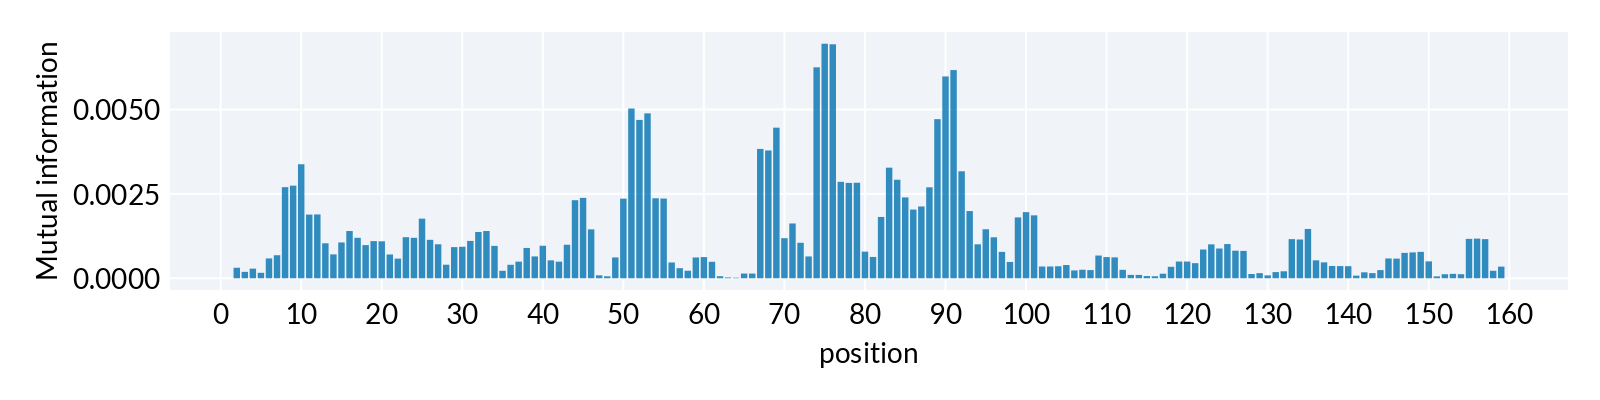

In [99]:
df_ykge = CSV.read("ykgE_dataset_combined.csv", DataFrame)
df_ykge.seq = map(x -> x[1:160], df_ykge.seq)
rename!(df_ykge, "seq" => "promoter")
x = wgregseq.footprints.mutual_information_mutation(df_ykge)
#x = wgregseq.footprints.mutual_information_bases(df, nbins=2)
fig = Figure(size=(800, 200))
ax = Axis(fig[1, 1], xlabel="position", ylabel="Mutual information", xticks=0:10:180)
d=1
barplot!(1+d:160-d, [mean(x[i-d:i+d]) for i in 1+d:160-d])

fig

### Plot relative entropy from mpathic

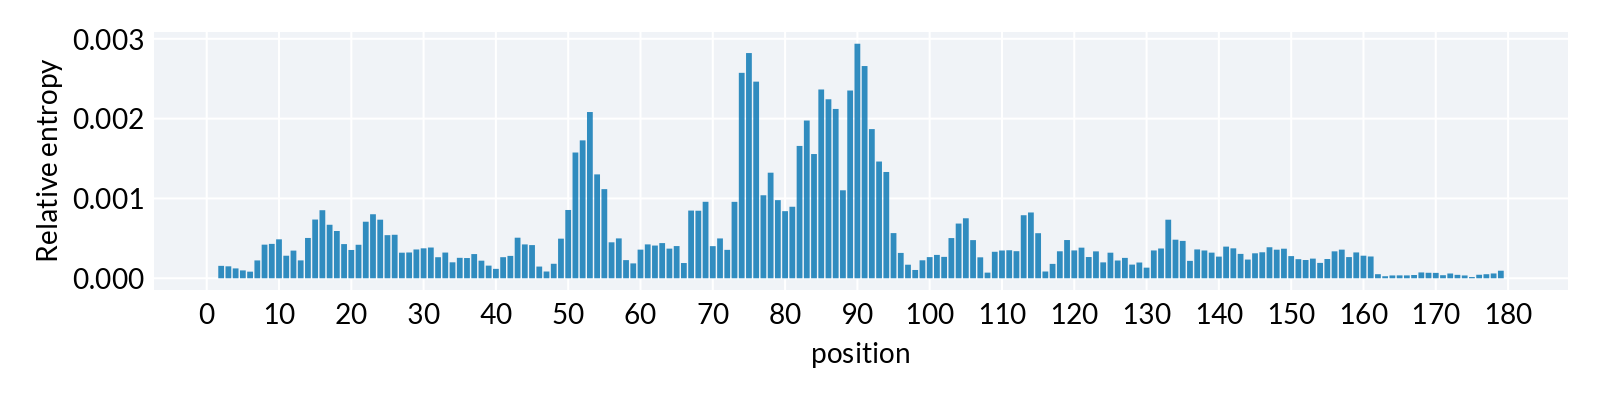

In [100]:
df_ykge_mat = CSV.read("ykgE_elife.csv", DataFrame, ignorerepeated=true, delim=" ")
ykgE_mat = df_ykge_mat[:, [:val_A, :val_C, :val_G, :val_T]] |> Matrix
prob_mat = exp.(ykgE_mat) ./ sum(exp.(ykgE_mat), dims=2)
mut_info = sum(prob_mat .* log2.(prob_mat ./ 0.25), dims=2) |> vec

d = 1

fig = Figure(size=(800, 200))
ax = Axis(fig[1, 1], xlabel="position", ylabel="Relative entropy", xticks=0:10:180)

barplot!(ax, 1+d:180-d, [mean(mut_info[i-d:i+d]) for i in 1+d:180-d])
fig

### Reproduce data processing

In [101]:
df_ykge

Row,ct,ct_0,ct_1,promoter
,Float64,Float64,Float64,String
1,1.0,1.0,0.0,ACAATTTCACCATAAAATGTCGGCGTTGCCGAAAGAAATAAAATGAGGTATTGCATTTGACGTTTGGATGAAAGATTTTCATTTGTCCTACAATTGCGGGGTGGTATGTGGCTAGCCCATTAAAAAAGAACGCCATATTTATTGATGATTGACACCGCGG
2,1.0,1.0,0.0,ACGAATTCCCCATAAGAAGTAAGCGATGCAGAAAGAAATAAAATTAGTTATCGCATTGGGGGTTTGCATCAAAGATTATCATTTGTCATACAGATGAGGGGGGGTATGTTGCTAGTCACTTAAACAAGAACGCCCTAGTTATTGATGAATGATCCTCCGG
3,1.0,1.0,0.0,ACGAATTCCCCATAAGAAGTAAGCGATGCAGAAAGAAATAAAATTAGTTATCGCATTGGGGGTTTGCATCAAAGATTATCATTTGTCATACAGATGAGGGGGGGTATGTTGCTAGTCACTTAAACAAGAACGCCCTAGTTATTGATGAATGATCCTCCGG
4,2.0,2.0,0.0,ACGACTTGCCCAATAAATGTGAGCGTTGCCAAAAGGAATACAATGAGTTATTTCATTTGACGTTTGGGTGAAAGATTATCATTTGTCATACAAATGAAGGCTGGTATGTCGCTAGCCTATTAAAAAAGAACGCCATATATATTGGTCATTGATCCCGCGG
5,2.0,2.0,0.0,ACGACTTGCCCAATAAATGTGAGCGTTGCCAAAAGGAATACAATGAGTTATTTCATTTGACGTTTGGGTGAAAGATTATCATTTGTCATACAAATGAAGGCTGGTATGTCGCTAGCCTATTAAAAAAGAACGCCATATATATTGGTCATTGATCCCGCGG
6,1.0,1.0,0.0,ACGAGTTCCCCATAAAATTTGAGCGATGCCGAAAGAAATAAAAGTAGTTATTACATTCGTCGTATGGATGAAGGCTTATGATTTGTCATACAGAGGAGGGGTGGTATCTTGATGGCCAATGAAATCAGAACGCCATATTTATTGATGATTGATCCCCCGG
7,1.0,1.0,0.0,ACGATTATCCCATAAAATGTGAACGATGCCGAAAGAAATAAAATTAGTTACTGCATTTGACGTTTGGATGTAAGTTTATCATTCGTAATAGAAATGAGGGGTGGTATGTTGGTACCCAATTAAAAAAGAACGCCTTATTTATTGATGATTGTTCCCCCGG
8,2.0,2.0,0.0,ACGATTATCCCATAAAATGTGAACGATGCCGAAAGAAATAAAATTAGTTACTGCATTTGACGTTTGGATGTAAGTTTATCATTCGTAATAGAAATGAGGGGTGGTATGTTGGTACCCAATTAAAAAAGAACGCCTTATTTATTGATGATTGTTCCCCCGG
9,2.0,2.0,0.0,ACGATTATCCCATAAAATGTGAACGATGCCGAAAGAAATAAAATTAGTTACTGCATTTGACGTTTGGATGTAAGTTTATCATTCGTAATAGAAATGAGGGGTGGTATGTTGGTACCCAATTAAAAAAGAACGCCTTATTTATTGATGATTGTTCCCCCGG


In [184]:
function sum_rows_by_vector(m::AbstractMatrix, v::AbstractVector)::Dict
    # Check if dimensions are compatible
    if length(v) != size(m, 1)
        error("The length of the vector must match the number of rows in the matrix.")
    end

    # Identify unique elements in the vector
    unique_elements = unique(v)

    # Initialize a dictionary to hold the sums
    sums = Dict(el => zeros(size(m, 2)) for el in unique_elements)

    # Iterate through the vector and sum the rows of the matrix
    for (i, el) in enumerate(v)
        sums[el] += m[i, :]
    end
    return sums
end

function phenotype_map(mu::AbstractMatrix, θ::AbstractVector; coarse_graining_level=0.01, n_groups=500)
    cts_grouped = zeros(Float64, n_groups, 2)
    temp_df = copy(df)
    if coarse_graining_level > 0
        scale = std(θ)
        temp_θ = floor.((θ ./ scale) ./ coarse_graining_level)
        ct_dict = sum_rows_by_vector(mu, temp_θ)
    else
        ct_dict = sum_rows_by_vector(mu, θ)
    end

    cts_per_group = sum(mu) / n_groups

    group_num = 1
    frac_empty = 1.0
    group_vec = zeros(2)
    for key in sort(keys(ct_dict) |> collect)
        row_ct_vec = ct_dict[key]
        row_ct_tot = sum(row_ct_vec)

        row_frac_vec = row_ct_vec ./ row_ct_tot 
        while row_ct_tot >= cts_per_group * frac_empty
            group_vec = group_vec + row_frac_vec * (cts_per_group * frac_empty)
            row_ct_tot -= cts_per_group * frac_empty

            # Only do once per group_num
            cts_grouped[group_num, :] .= group_vec
            # Reset for new group_num
            group_num += 1
            frac_empty = 1.0
            group_vec[:] .= 0.0
        end
        group_vec += row_frac_vec * row_ct_tot
        
        frac_empty -= row_ct_tot / cts_per_group
    end    
    if group_num == n_groups-1
        cts_grouped[group_num, :] .= group_vec
    end
    # Smooth empirical distribution with gaussian KDE
    f_reg = imfilter(cts_grouped, Kernel.gaussian(0.04 * n_groups))

    f_reg ./= sum(f_reg)
    p = wgregseq.footprints.mutual_information_add_model(f_reg)
    return p * sum(mu)
end

using BenchmarkTools
@btime phenotype_map(df_ykge[!, [:ct_0, :ct_1]] |> Matrix, rand(nrow(df_ykge))) 

  1.639 ms (7706 allocations: 5.11 MiB)


0.004154454625811517

In [191]:
function get_data(df)
    seq_mat = sparse(vcat([vcat(wgregseq.utils.onehot_encoder.(seq)'...)' for seq in df.promoter]...));
    return seq_mat
end

function density_func(seq_mat::SparseMatrixCSC{Int64, Int64}, mu::AbstractMatrix, θ::Matrix{Float64}, n)
    en = (seq_mat * vec(θ))
    return phenotype_map(mu, en)
end

density_func (generic function with 1 method)

In [198]:
seq_mat = get_data(df_ykge)
mu = df_ykge[!, [:ct_0, :ct_1]] |> Matrix

density_func(seq_mat, mu, ykgE_mat[1:160, :]' |> Matrix, 1)

0.4247708867988882

In [199]:
ykgE_mat' |> Matrix

4×180 Matrix{Float64}:
  0.01454    0.023509  -0.003412  …  -0.000617   0.005982  -0.008573
  0.001685  -0.002869   0.020748      0.003695  -0.00293    0.006331
 -0.022539  -0.023115  -0.016885      0.005405   0.008917   0.024324
  0.006314   0.002475  -0.000451     -0.008484  -0.011969  -0.022082

In [ ]:

warmup_steps = 50000
sample_steps = 550000
thin = 10
adapt_steps = 1000

total_steps = warmup_steps + sample_steps

# Construct a DensityModel.
model = wgregseq.footprints.DensityModel(density_func, mu, seq_mat)

# Set up our sampler with initial parameters.
spl = wgregseq.footprints.MetropolisHastings(randn(4, 160))

# Run sampler
chain, tracker = StatsBase.sample(model, spl, total_steps, seq_mat, thin=thin, adapt_steps=adapt_steps)

# Return parameters
x = reshape(mean(chain[1][Int64(warmup_steps/thin):Int64(total_steps/thin), 1:640], dims=1), 4, 160)


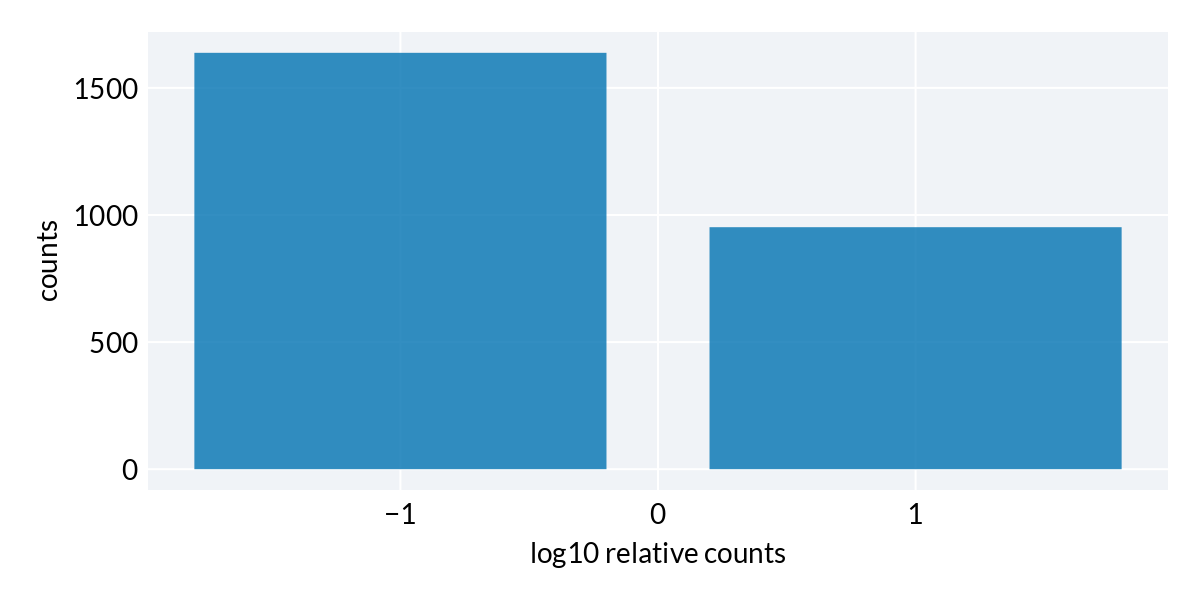

In [82]:
function expand_df(df, count_col)
    # Convert the count column to integers if it's not already
    df[!, count_col] = Int64.(df[!, count_col])

    return vcat([repeat(df[i:i, :], df[i, count_col]) for i in 1:nrow(df)]...)
end

expanded_df = insertcols(expand_df(df, :ct_0)[!, [:promoter]], 2, :mu => 0)
expanded_df = append!(expanded_df, insertcols(expand_df(df, :ct_1)[!, [:promoter]], 2, :mu => 1))
mu = expanded_df.mu

seq_mat = get_data_(expanded_df)

length (generic function with 320 methods)

## Run on sample data set

In [83]:
# transform dataset
thin = 10
warmup_steps = 50000
sample_steps = 500000
mat, tracker, chain = wgregseq.footprints.run_mcmc(seq_mat, mu, warmup_steps=warmup_steps, sample_steps=sample_steps, thin=thin, adapt_steps=1000)

10000 of 550000 done.
Density: 3.9446941405299576
20000 of 550000 done.


Density: 4.130964531563341


30000 of 550000 done.
Density: 0.6207557699141106
40000 of 550000 done.


Density: 2.2516009931496117


50000 of 550000 done.
Density: 2.7852005619231837
60000 of 550000 done.


Density: 3.987620484070946


70000 of 550000 done.
Density: 6.962664097661863
80000 of 550000 done.


Density: 5.647761952871166


90000 of 550000 done.
Density: 0.029626095584158917
100000 of 550000 done.


Density: 1.4371971910021395


110000 of 550000 done.
Density: 9.458681166646302


InterruptException: InterruptException:

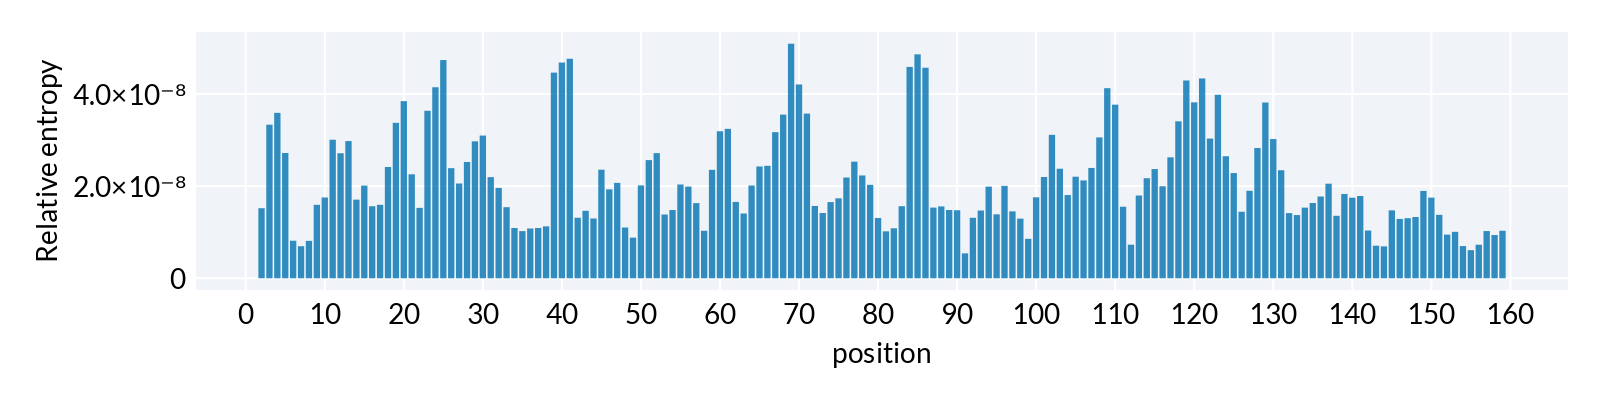

In [50]:
prob_mat = exp.(mat) ./ sum(exp.(mat), dims=1)
mut_info = sum(prob_mat .* log2.(prob_mat ./ 0.25), dims=1) |> vec

d=1

fig = Figure(size=(800, 200))
ax = Axis(fig[1, 1], xlabel="position", ylabel="Relative entropy", xticks=0:10:160)

barplot!(ax, 1+d:160-d, [mean(mut_info[i-d:i+d]) for i in 1+d:160-d])
fig

In [ ]:
indexes = Int(warmup_steps/thin):Int((warmup_steps+sample_steps)/thin)

fig = Figure(size=(800, 500))

# Log likelihood tracker
ax = Axis(fig[1 ,1], title="log likelihood", xlabel="steps")
lines!(ax, 1:thin:thin*length(tracker), tracker)
#vlines!(ax, [50000], color="gray", linestyle=:dash)

# Mean Autocorrelation function
ax2 = Axis(fig[1 ,2], title="Mean\nAuto Correlation", xlabel="steps")
lines!(ax2, mean(autocor(chain[1][indexes[1:end], 393:424], 1:1:10000), dims=2)|>vec, label="-10 region")
lines!(ax2, mean(autocor(chain[1][indexes[1:end], 601:632], 1:1:10000), dims=2)|>vec, label="105-112")

# Traces of 4 different parameters
ax3 = Axis(fig[2, 1:2], title="Trace", xlabel="steps")
lines!(ax3, warmup_steps:thin:thin*length(tracker), chain[1][indexes, 1])
lines!(ax3, warmup_steps:thin:thin*length(tracker), chain[1][indexes, 100])
lines!(ax3, warmup_steps:thin:thin*length(tracker), chain[1][indexes, 200])
lines!(ax3, warmup_steps:thin:thin*length(tracker), chain[1][indexes, 300])


fig

In [51]:
tracker

55000-element Vector{Float64}:
 0.39950343651507014
 0.6280486082393448
 1.9086171332945756
 0.35027336247117186
 0.2501688027730196
 0.7906205893408095
 0.6988470045517343
 0.5282060785751799
 0.1945699871011255
 0.5485819416344732
 ⋮
 0.5794949830693039
 1.1326308386362103
 1.1675228370947126
 1.03581718076349
 0.7764928708471647
 0.3851555109699226
 0.9914459243293512
 0.6922315896478928
 0.3955046912438769

## Import data

In [55]:
if isfile("filtered_mapping.csv")
    df_map = CSV.read("filtered_mapping.csv", DataFrame)
else
    df_map = CSV.read(
        "../../../data/barcodes/20220514_mapping/mapped_barcodes.csv", 
        DataFrame, 
    );

    # Filter out unnannotad sequences
    df_map = df_map[df_map.name .!= "*", :]

    # Filter out non-unique barcodes
    gdf = groupby(df_map[(df_map.map_count .> 2), :], :barcode)
    _df = DataFrame()
    for df in gdf
        if nrow(df) == 1
            append!(_df, df)
        end
    end
    df_map = copy(_df);

    # Get twist order to get wild type sequences
    df_seqs = wgregseq.utils.import_twist_order("../../../data/twist_orders/2022-02-15_twist_order.csv")
    df_wt = df_seqs[1:1501:119*1501, :];
    insertcols!(df_wt, 4, :promoter_seq => [string(x[27:186]) for x in df_wt.sequence])

    df_wt.promoter_seq |> unique |> length
    df_map = leftjoin(df_map, rename(df_wt[!, [:promoter, :promoter_seq]], :promoter => :name), on="name")
    rename!(df_map, :promoter_seq => :wt_seq);

    CSV.write("filtered_mapping.csv", df_map)
end

"filtered_mapping.csv"

In [56]:
function get_dataset(i)
    if  isfile("../../../data/extracted_barcodes/20231207_barcode/$(i)_DNA_collapsed.txt")
        df_DNA = CSV.read(
            "../../../data/extracted_barcodes/20231207_barcode/$(i)_DNA_collapsed.txt", 
            DataFrame, 
            ignorerepeated=true, 
            delim=" ", 
            header=["ct_0", "barcode"]
        )
        # import RNA
        df_RNA = CSV.read(
            "../../../data/extracted_barcodes/20231207_barcode/$(i)_RNA_collapsed.txt", 
            DataFrame, 
            ignorerepeated=true, 
            delim=" ", 
            header=["ct_1", "barcode"]
        )
    else
        df_DNA = CSV.read(
            "../../../data/extracted_barcodes/20230907_barcode/temp/$(i)_DNA_collapsed.txt", 
            DataFrame, 
            ignorerepeated=true, 
            delim=" ", 
            header=["ct_0", "barcode"]
        )
        # import RNA
        df_RNA = CSV.read(
            "../../../data/extracted_barcodes/20230907_barcode/temp/$(i)_RNA_collapsed.txt", 
            DataFrame, 
            ignorerepeated=true, 
            delim=" ", 
            header=["ct_1", "barcode"])
    end
    
    # merge DNA and RNA reads
    df = outerjoin(df_DNA, df_RNA, on=:barcode)
    
    # replace missing reads with 0
    replace!(df.ct_0, missing => 0)
    replace!(df.ct_1, missing => 0)
    
    # identify promoter sequences
    df = innerjoin(df, df_map, on=:barcode)
    
    # compute total counts
    insertcols!(df, 1, :ct => df.ct_0 .+ df.ct_1)
    insertcols!(df, 1, :relative_counts => (df.ct_1 .+ 1) ./ (df.ct_0 .+ 1))
    
    # Turn sequences into integer
    insertcols!(df, 3, :int_promoter => wgregseq.footprints.make_int.(df[:, :promoter]))
    insertcols!(df, 3, :int_wt => wgregseq.footprints.make_int.(df[:, :wt_seq]));
    return df
end

get_dataset (generic function with 1 method)

In [57]:
df = get_dataset("3-2");
df = df[df.name .== "dicCp", :];

In [58]:
df

Row,relative_counts,ct,int_wt,int_promoter,ct_0,barcode,ct_1,promoter,map_count,name,wt_seq
,Float64,Int64,Array…,Array…,Int64?,String31,Int64?,String,Int64,String,String?
1,0.333333,2,"[3, 1, 3, 3, 4, 4, 4, 4, 4, 2 … 2, 4, 3, 1, 2, 3, 2, 4, 2, 4]","[1, 1, 2, 3, 4, 4, 2, 4, 4, 2 … 2, 4, 3, 1, 2, 3, 2, 4, 4, 4]",2,TGGATGTGTCCGAGTCCGCG,0,AACGTTCTTCCGACGATACCTGATGCGTTCGCAGATAGTTAAATTTTTTGTTTGCATAGGTAGCTAATCTTAAATCGCATTGACTATGTTCTGGTAAACATCTATCTTGTTAGTTATGACCAACATTAAAGGTGTTTGAAATGCTTAAAACTGACGCTTT,117,dicCp,GAGGTTTTTCCGACGATACCTGATGCGTTCGCCGATAGTTAAATTTTTTGTTTCCATAGTTAGCTAATGCTAAATCGTATTGACTATGTTTTTGTTAACATCTATCTTGTTAGTTATGACTAACAATAAAGGTGTTTTAAATGCTTAAAACTGACGCTCT
2,17.6,91,"[3, 1, 3, 3, 4, 4, 4, 4, 4, 2 … 2, 4, 3, 1, 2, 3, 2, 4, 2, 4]","[1, 1, 2, 3, 4, 4, 2, 4, 4, 2 … 2, 4, 3, 1, 2, 3, 2, 4, 4, 4]",4,AAGTTAAGAGGCATAAGGTG,87,AACGTTCTTCCGACGATACCTGATGCGTTCGCAGATAGTTAAATTTTTTGTTTGCATAGGTAGCTAATCTTAAATCGCATTGACTATGTTCTGGTAAACATCTATCTTGTTAGTTATGACCAACATTAAAGGTGTTTGAAATGCTTAAAACTGACGCTTT,24,dicCp,GAGGTTTTTCCGACGATACCTGATGCGTTCGCCGATAGTTAAATTTTTTGTTTCCATAGTTAGCTAATGCTAAATCGTATTGACTATGTTTTTGTTAACATCTATCTTGTTAGTTATGACTAACAATAAAGGTGTTTTAAATGCTTAAAACTGACGCTCT
3,14.5,29,"[3, 1, 3, 3, 4, 4, 4, 4, 4, 2 … 2, 4, 3, 1, 2, 3, 2, 4, 2, 4]","[1, 1, 2, 3, 4, 4, 2, 4, 4, 2 … 2, 4, 3, 1, 2, 3, 2, 4, 4, 4]",1,ACTCGCCCTCGGGACTTTTG,28,AACGTTCTTCCGACGATACCTGATGCGTTCGCAGATAGTTAAATTTTTTGTTTGCATAGGTAGCTAATCTTAAATCGCATTGACTATGTTCTGGTAAACATCTATCTTGTTAGTTATGACCAACATTAAAGGTGTTTGAAATGCTTAAAACTGACGCTTT,36,dicCp,GAGGTTTTTCCGACGATACCTGATGCGTTCGCCGATAGTTAAATTTTTTGTTTCCATAGTTAGCTAATGCTAAATCGTATTGACTATGTTTTTGTTAACATCTATCTTGTTAGTTATGACTAACAATAAAGGTGTTTTAAATGCTTAAAACTGACGCTCT
4,16.4375,277,"[3, 1, 3, 3, 4, 4, 4, 4, 4, 2 … 2, 4, 3, 1, 2, 3, 2, 4, 2, 4]","[1, 1, 2, 3, 4, 4, 2, 4, 4, 2 … 2, 4, 3, 1, 2, 3, 2, 4, 4, 4]",15,CAATTTACCGAGACCGGGGG,262,AACGTTCTTCCGACGATACCTGATGCGTTCGCAGATAGTTAAATTTTTTGTTTGCATAGGTAGCTAATCTTAAATCGCATTGACTATGTTCTGGTAAACATCTATCTTGTTAGTTATGACCAACATTAAAGGTGTTTGAAATGCTTAAAACTGACGCTTT,9,dicCp,GAGGTTTTTCCGACGATACCTGATGCGTTCGCCGATAGTTAAATTTTTTGTTTCCATAGTTAGCTAATGCTAAATCGTATTGACTATGTTTTTGTTAACATCTATCTTGTTAGTTATGACTAACAATAAAGGTGTTTTAAATGCTTAAAACTGACGCTCT
5,0.5,1,"[3, 1, 3, 3, 4, 4, 4, 4, 4, 2 … 2, 4, 3, 1, 2, 3, 2, 4, 2, 4]","[1, 1, 2, 3, 4, 4, 2, 4, 4, 2 … 2, 4, 3, 1, 2, 3, 2, 4, 4, 4]",1,CCAGAAGGGACAAAAATCCG,0,AACGTTCTTCCGACGATACCTGATGCGTTCGCAGATAGTTAAATTTTTTGTTTGCATAGGTAGCTAATCTTAAATCGCATTGACTATGTTCTGGTAAACATCTATCTTGTTAGTTATGACCAACATTAAAGGTGTTTGAAATGCTTAAAACTGACGCTTT,129,dicCp,GAGGTTTTTCCGACGATACCTGATGCGTTCGCCGATAGTTAAATTTTTTGTTTCCATAGTTAGCTAATGCTAAATCGTATTGACTATGTTTTTGTTAACATCTATCTTGTTAGTTATGACTAACAATAAAGGTGTTTTAAATGCTTAAAACTGACGCTCT
6,1.38462,29,"[3, 1, 3, 3, 4, 4, 4, 4, 4, 2 … 2, 4, 3, 1, 2, 3, 2, 4, 2, 4]","[1, 1, 2, 3, 4, 4, 2, 4, 4, 2 … 2, 4, 3, 1, 2, 3, 2, 4, 4, 4]",12,CCATGCCAAGTAGATACAAA,17,AACGTTCTTCCGACGATACCTGATGCGTTCGCAGATAGTTAAATTTTTTGTTTGCATAGGTAGCTAATCTTAAATCGCATTGACTATGTTCTGGTAAACATCTATCTTGTTAGTTATGACCAACATTAAAGGTGTTTGAAATGCTTAAAACTGACGCTTT,53,dicCp,GAGGTTTTTCCGACGATACCTGATGCGTTCGCCGATAGTTAAATTTTTTGTTTCCATAGTTAGCTAATGCTAAATCGTATTGACTATGTTTTTGTTAACATCTATCTTGTTAGTTATGACTAACAATAAAGGTGTTTTAAATGCTTAAAACTGACGCTCT
7,2.0,1,"[3, 1, 3, 3, 4, 4, 4, 4, 4, 2 … 2, 4, 3, 1, 2, 3, 2, 4, 2, 4]","[1, 1, 2, 3, 4, 4, 2, 4, 4, 2 … 2, 4, 3, 1, 2, 3, 2, 4, 4, 4]",0,CTACGCTTAAGCCCCATTCT,1,AACGTTCTTCCGACGATACCTGATGCGTTCGCAGATAGTTAAATTTTTTGTTTGCATAGGTAGCTAATCTTAAATCGCATTGACTATGTTCTGGTAAACATCTATCTTGTTAGTTATGACCAACATTAAAGGTGTTTGAAATGCTTAAAACTGACGCTTT,18,dicCp,GAGGTTTTTCCGACGATACCTGATGCGTTCGCCGATAGTTAAATTTTTTGTTTCCATAGTTAGCTAATGCTAAATCGTATTGACTATGTTTTTGTTAACATCTATCTTGTTAGTTATGACTAACAATAAAGGTGTTTTAAATGCTTAAAACTGACGCTCT
8,18.5,76,"[3, 1, 3, 3, 4, 4, 4, 4, 4, 2 … 2, 4, 3, 1, 2, 3, 2, 4, 2, 4]","[1, 1, 2, 3, 4, 4, 2, 4, 4, 2 … 2, 4, 3, 1, 2, 3, 2, 4, 4, 4]",3,GACCACCGAACCACATGTAT,73,AACGTTCTTCCGACGATACCTGATGCGTTCGCAGATAGTTAAATTTTTTGTTTGCATAGGTAGCTAATCTTAAATCGCATTGACTATGTTCTGGTAAACATCTATCTTGTTAGTTATGACCAACATTAAAGGTGTTTGAAATGCTTAAAACTGACGCTTT,76,dicCp,GAGGTTTTTCCGACGATACCTG

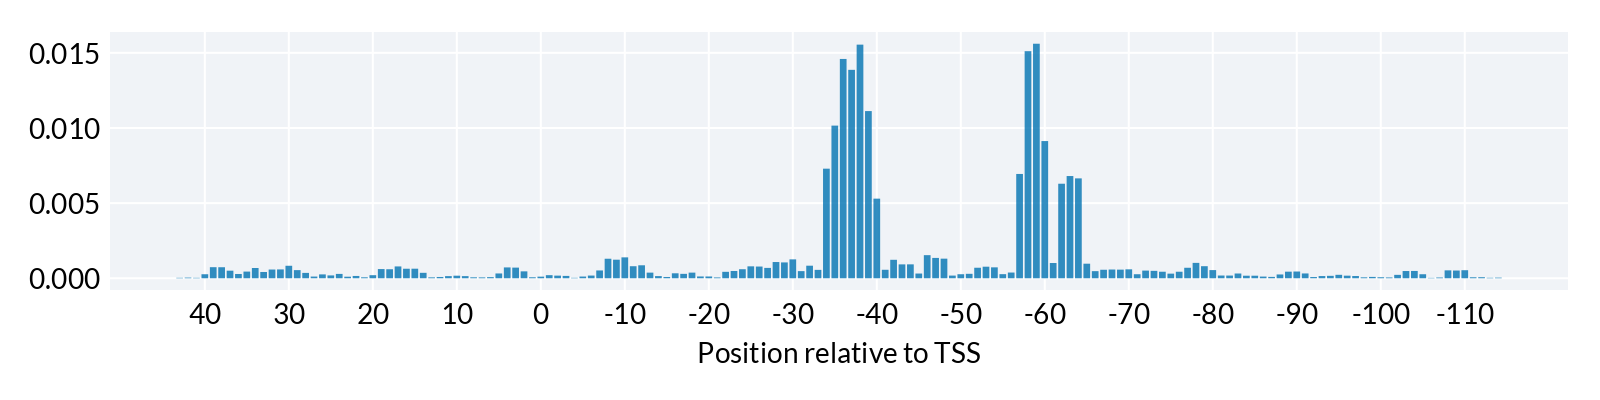

In [59]:
x = wgregseq.footprints.mutual_information_mutation(df)
#x = wgregseq.footprints.mutual_information_bases(df, nbins=2)
fig = Figure(size=(800, 200))
ax = Axis(fig[1, 1], xlabel="Position relative to TSS", xticks=(5:10:155, ["$i" for i in 40:-10:-110]))
d=1
barplot!(1+d:160-d, [mean(x[i-d:i+d]) for i in 1+d:160-d])

fig

In [60]:
function get_data(df)
    #seq_vec_0 = vcat([fill(i, df.ct_0[i]) for i in 1:nrow(df)]...)
    #mu0 = fill(0, length(seq_vec_0))

    #seq_vec_1 = vcat([fill(i, df.ct_1[i]) for i in 1:nrow(df)]...)
    #mu1 = fill(1, length(seq_vec_1))

    #mu = vcat(mu0, mu1)
    mu = log10.((df.ct_1 .+ 1) ./ (df.ct_0 .+ 1))
    seq_mat = sparse(vcat([vcat(wgregseq.utils.onehot_encoder.(seq)'...)' for seq in df.promoter]...));
    return seq_mat, mu
end

get_data (generic function with 1 method)

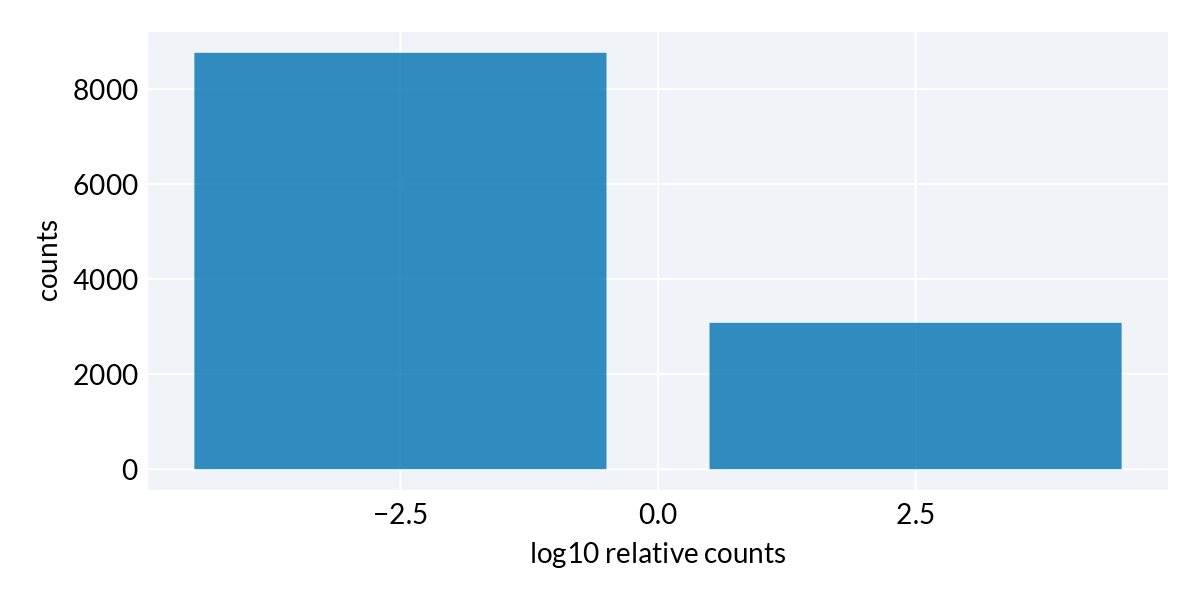

In [61]:
seq_mat, mu = get_data(df)

y = fit(Histogram, mu, nbins=2)

fig = Figure(size=(600, 300))
ax = Axis(fig[1, 1], xlabel="log10 relative counts", ylabel="counts")
barplot!(ax, y)
fig

## Run on sample data set

In [62]:
# transform dataset
seq_mat, mu = get_data(df)
thin = 10
warmup_steps = 50000
sample_steps = 500000
mat, tracker, chain = wgregseq.footprints.run_mcmc(seq_mat, mu, warmup_steps=warmup_steps, sample_steps=sample_steps, thin=thin, adapt_steps=1000)

10000 of 550000 done.
Density: 2.2151300627621238
20000 of 550000 done.


Density: 30.62305967818833


30000 of 550000 done.
Density: 102.83384532949937
40000 of 550000 done.


Density: 116.9344131379501


InterruptException: InterruptException:

### Diagnostics

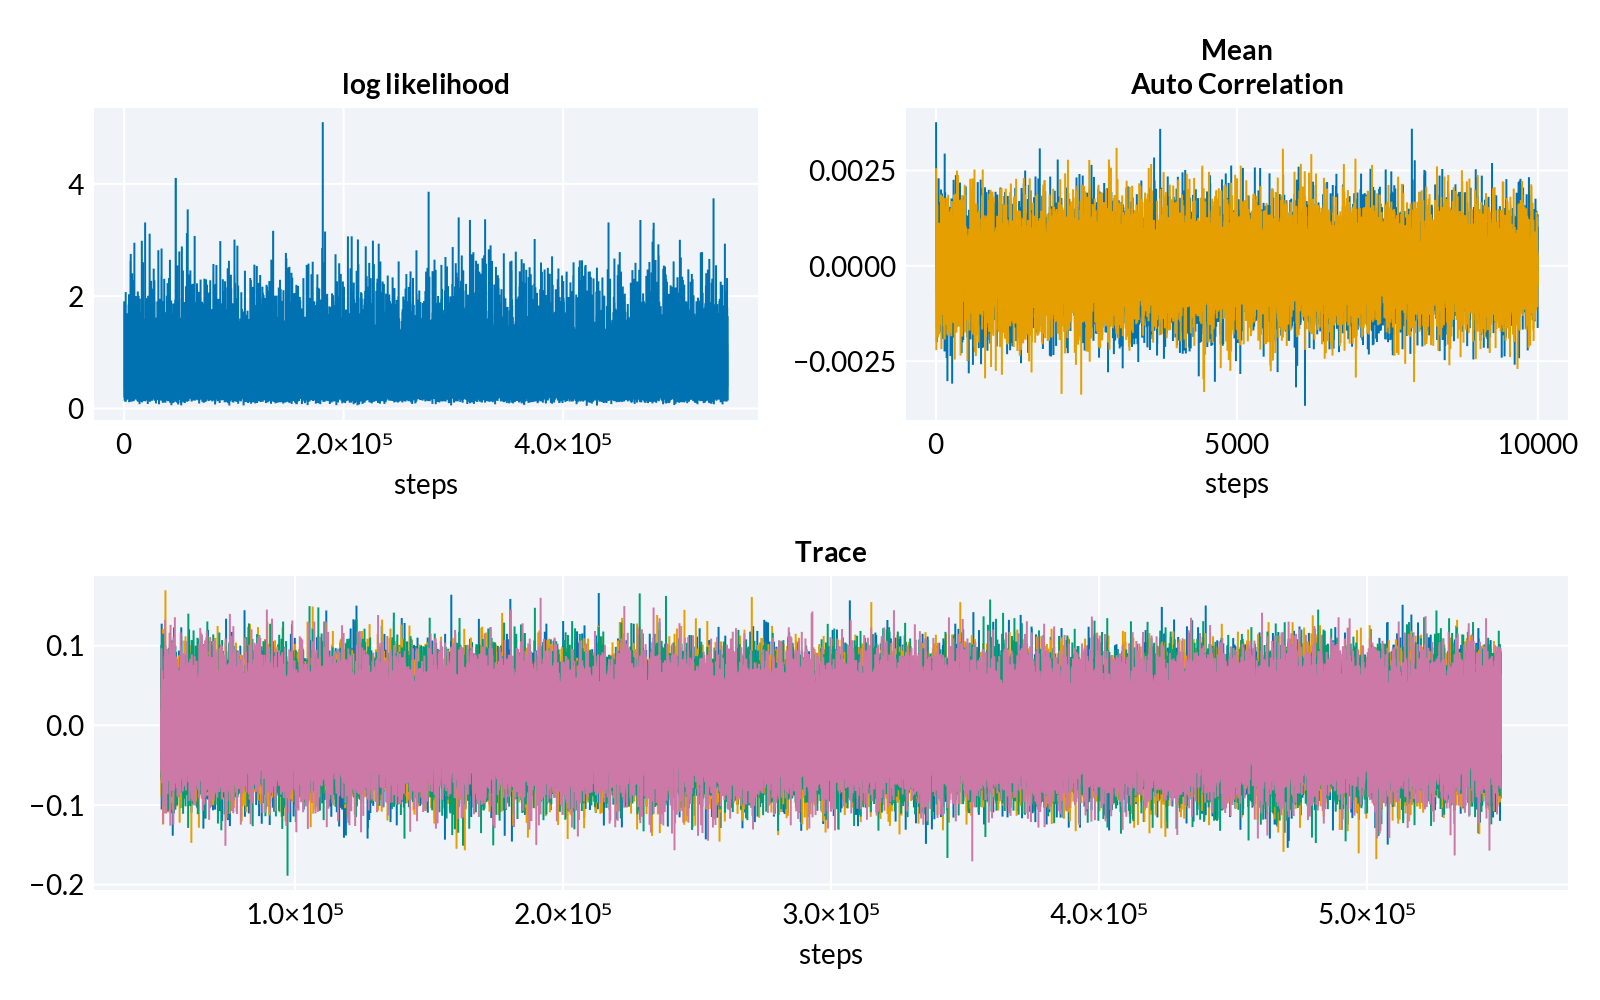

In [63]:
indexes = Int(warmup_steps/thin):Int((warmup_steps+sample_steps)/thin)

fig = Figure(size=(800, 500))

# Log likelihood tracker
ax = Axis(fig[1 ,1], title="log likelihood", xlabel="steps")
lines!(ax, 1:thin:thin*length(tracker), tracker)
#vlines!(ax, [50000], color="gray", linestyle=:dash)

# Mean Autocorrelation function
ax2 = Axis(fig[1 ,2], title="Mean\nAuto Correlation", xlabel="steps")
lines!(ax2, mean(autocor(chain[1][indexes[1:end], 393:424], 1:1:10000), dims=2)|>vec, label="-10 region")
lines!(ax2, mean(autocor(chain[1][indexes[1:end], 601:632], 1:1:10000), dims=2)|>vec, label="105-112")

# Traces of 4 different parameters
ax3 = Axis(fig[2, 1:2], title="Trace", xlabel="steps")
lines!(ax3, warmup_steps:thin:thin*length(tracker), chain[1][indexes, 1])
lines!(ax3, warmup_steps:thin:thin*length(tracker), chain[1][indexes, 100])
lines!(ax3, warmup_steps:thin:thin*length(tracker), chain[1][indexes, 200])
lines!(ax3, warmup_steps:thin:thin*length(tracker), chain[1][indexes, 300])


fig

In [160]:
indexes[1:10:end]

5000:10:55000

### Results

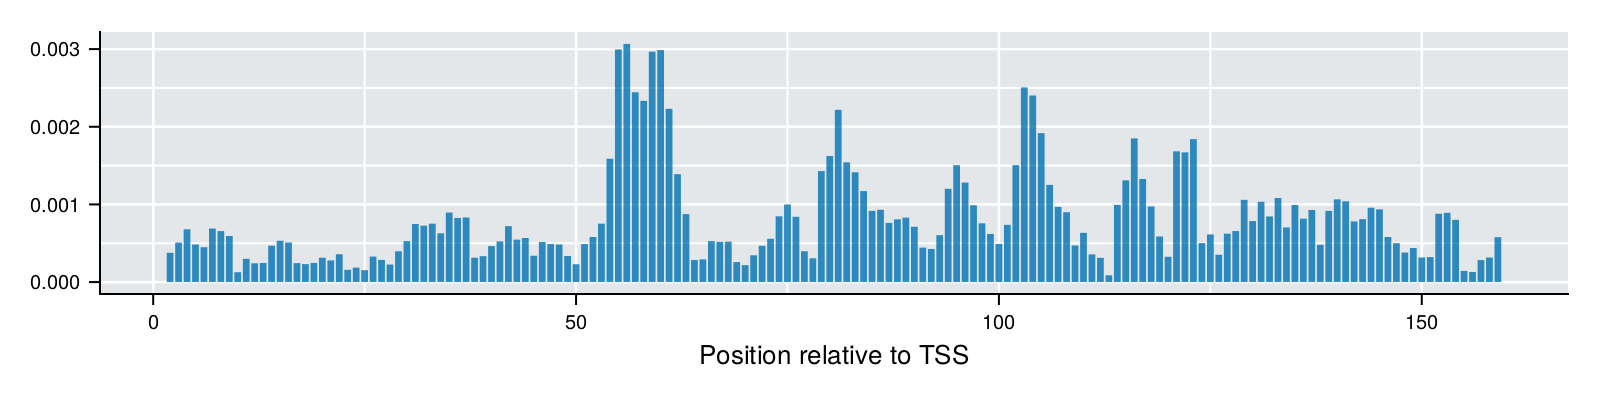

In [161]:
x = reshape(mean(chain[1][5001:100:end, 1:640], dims=1), 4, 160)
prob_mat = exp.(x) ./ sum(exp.(x), dims=1)
mut_info = sum([x * log2(x/0.25) for x in prob_mat], dims=1)

fig = Figure(size=(800, 200))
ax = Axis(fig[1, 1], xlabel="Position relative to TSS")#, xticks=(5:10:155, ["$i" for i in 40:-10:-110]))
d=1
barplot!(1+d:160-d, reverse([mean(mut_info[i-d:i+d]) for i in 1+d:160-d]))
#barplot!(1:160, mut_info|> vec)

fig

In [139]:
x = reshape(mean(chain[1][501:end, 393:424], dims=1), 4, 8)
prob_mat = exp.(x) ./ sum(exp.(x), dims=1)
mut_info = sum([x * log2(x/0.25) for x in prob_mat], dims=1)
mut_info |> print

[0.002180253442859754 0.0016692736361132478 0.002683597208366459 0.004478199165297982 0.0015997616763983227 0.0008532007236778348 0.00470042476992074 0.003416754119344889]

In [140]:
x = reshape(mean(chain[1][501:end, 601:632], dims=1), 4, 8)
prob_mat = exp.(x) ./ sum(exp.(x), dims=1)
mut_info = sum([x * log2(x/0.25) for x in prob_mat], dims=1)
mut_info |> print

[0.00016444766679312751 6.851802906091648e-5 0.0014477358988035406 0.0003701205772897419 0.00016202669305828352 0.0007539193251514739 0.0004753869091500343 0.0007712220275012376]

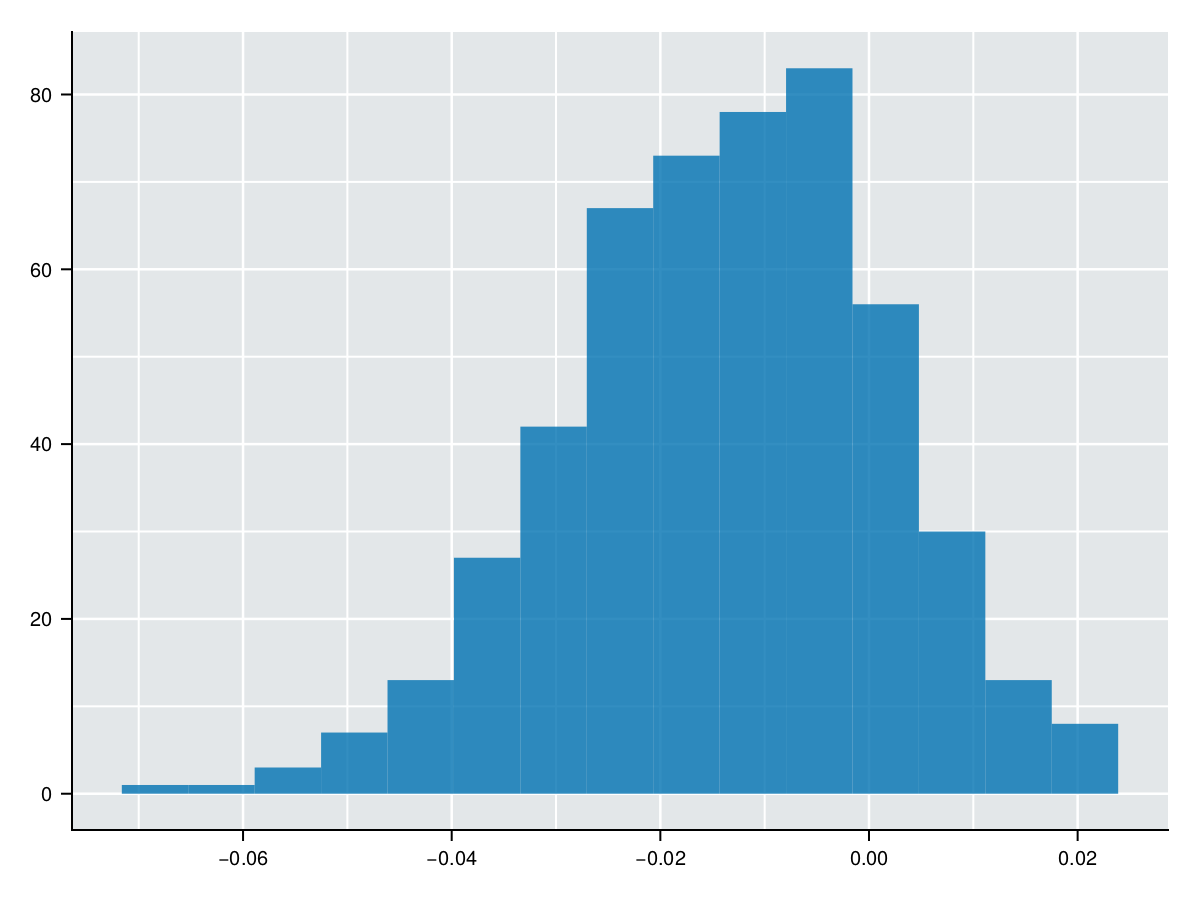

In [103]:
hist(chain[1][5000:end, 10])